In [1]:
# list of all files in the hadoop folder
import subprocess
subprocess.run(['hdfs', 'dfs', '-put', '-f', './Downloads/hotel_clean.csv', '/data'], stdout=subprocess.PIPE, text=True)
result = subprocess.run(['hdfs', 'dfs', '-ls', '/data'], stdout=subprocess.PIPE, text=True)

print(result.stdout)

Found 8 items
-rw-r--r--   1 bigdata supergroup         61 2025-09-10 18:33 /data/ContainsNull.csv
-rw-r--r--   1 bigdata supergroup     143130 2025-09-10 18:33 /data/appl_stock.csv
-rw-r--r--   1 bigdata supergroup      72168 2025-11-17 22:06 /data/diabetes.csv
-rw-r--r--   1 bigdata supergroup   12484747 2025-11-28 18:59 /data/hotel_clean.csv
-rw-r--r--   1 bigdata supergroup       4618 2025-09-10 18:32 /data/iris.csv
-rw-r--r--   1 bigdata supergroup         73 2025-09-10 18:29 /data/people.json
-rw-r--r--   1 bigdata supergroup      60196 2025-09-10 18:31 /data/sql-practice.ipynb
-rw-r--r--   1 bigdata supergroup      61194 2025-09-10 18:30 /data/titanic.csv



In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HotelCancellations").getOrCreate()
from pyspark.sql import functions as F
from pyspark.sql import Window


# If your CSV has NO header row:
df = spark.read.csv('hdfs://localhost:9000/data/hotel_clean.csv', inferSchema=True, header=True)

df.printSchema()
df.show(5)

25/11/28 18:59:11 WARN Utils: Your hostname, Ubuntu resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/11/28 18:59:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: double (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

25/11/28 18:59:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+-----+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|  adr|required_car_parking_spaces|tota

In [3]:
# First few rows
df.show(5, truncate=False)

# Basic stats for numeric columns
numeric_cols = [
    "lead_time",
    "arrival_date_year",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests"
]

df.select(numeric_cols).describe().show()


+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+-----+---------------------------+-------------------------+------------------+-----------------------+
|hotel       |is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr  |required_car_parking_spaces|tota

+-------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+------------------+-------------------+--------------------+----------------------+------------------------------+-------------------+--------------------+------------------+---------------------------+-------------------------+
|summary|        lead_time| arrival_date_year|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|          children|             babies|   is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|    booking_changes|days_in_waiting_list|               adr|required_car_parking_spaces|total_of_special_requests|
+-------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+------------------+-------------------+--------------------

In [4]:
# Total bookings and cancellation rate
total_bookings = df.count()
cancel_stats = (
    df.groupBy("is_canceled")
      .count()
      .withColumn("percentage", F.col("count") / total_bookings)
)

cancel_stats.show()


+-----------+-----+-------------------+
|is_canceled|count|         percentage|
+-----------+-----+-------------------+
|          1|23839|0.27844745018338124|
|          0|61775| 0.7215525498166188|
+-----------+-----+-------------------+



In [5]:
# Booking behavior by hotel type
hotel_behavior = (
    df.groupBy("hotel")
      .agg(
          F.count("*").alias("bookings"),
          F.sum("is_canceled").alias("cancellations")
      )
      .withColumn("cancellation_rate", F.col("cancellations") / F.col("bookings"))
      .orderBy(F.col("cancellation_rate").desc())
)

hotel_behavior.show()


+------------+--------+-------------+-------------------+
|       hotel|bookings|cancellations|  cancellation_rate|
+------------+--------+-------------+-------------------+
|  City Hotel|   52349|        15938| 0.3044566276337657|
|Resort Hotel|   33265|         7901|0.23751690966481287|
+------------+--------+-------------+-------------------+



In [6]:
# 2. Basic feature engineering
#    (needed for some plots)
# ============================
df_fe = (
    df.withColumn(
        "total_nights",
        F.col("stays_in_weekend_nights") + F.col("stays_in_week_nights")
    )
    .withColumn(
        "total_guests",
        F.col("adults") + F.col("children") + F.col("babies")
    )
)

# Family / group indicator
df_fe = df_fe.withColumn(
    "is_family",
    F.when((F.col("children") > 0) | (F.col("babies") > 0), F.lit(1)).otherwise(F.lit(0))
)


df_fe = df_fe.withColumn(
    "lead_time_bucket",
    F.when(F.col("lead_time") <= 30, "0-30")
     .when((F.col("lead_time") > 30) & (F.col("lead_time") <= 90), "31-90")
     .otherwise("90+")
)

# ============================
# Helper: month order dict
# ============================
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
month_index = {m: i for i, m in enumerate(month_order)}


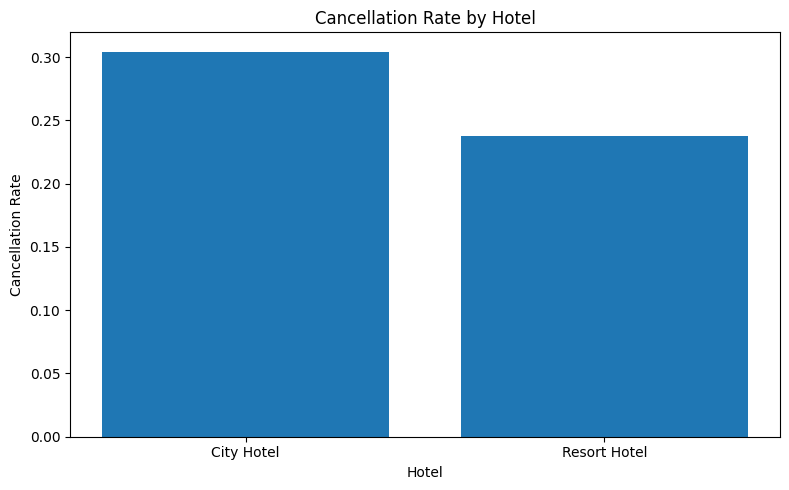

In [19]:
# ============================
# 1. Cancellation rate by hotel
# ============================
hotel_behavior = (
    df.groupBy("hotel")
      .agg(
          F.count("*").alias("bookings"),
          F.sum("is_canceled").alias("cancellations")
      )
      .withColumn("cancellation_rate", F.col("cancellations") / F.col("bookings"))
      .orderBy(F.col("cancellation_rate").desc())
)

hotel_rows = hotel_behavior.collect()

hotels = [r["hotel"] for r in hotel_rows]
hotel_rates = [r["cancellation_rate"] for r in hotel_rows]

plt.figure(figsize=(8, 5))
plt.bar(hotels, hotel_rates)
plt.xlabel("Hotel")
plt.ylabel("Cancellation Rate")
plt.title("Cancellation Rate by Hotel")
plt.tight_layout()
plt.show()


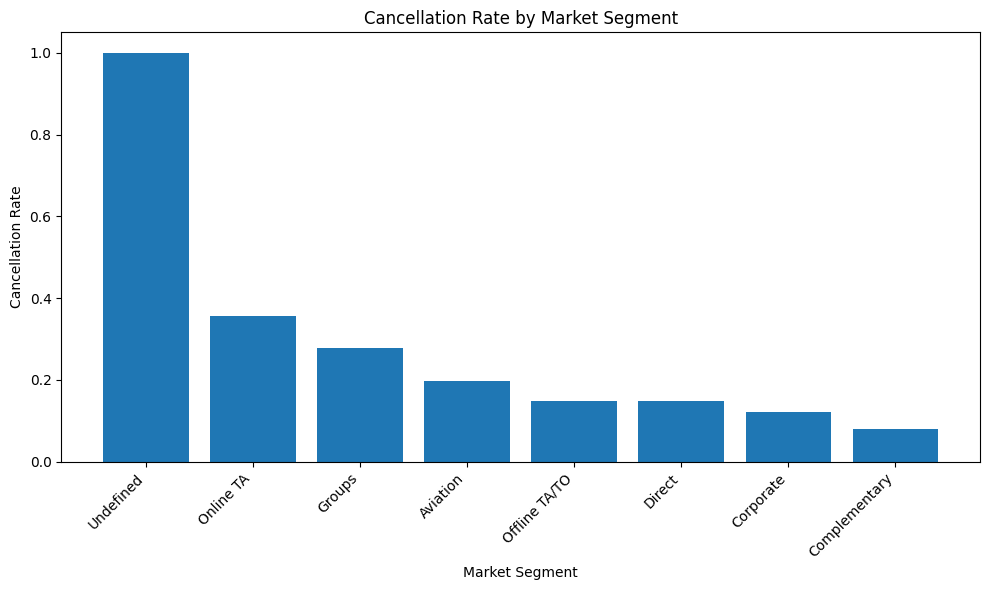

In [20]:
# ============================
# 2. Cancellation rate by market_segment
# ============================
market_seg = (
    df.groupBy("market_segment")
      .agg(
          F.count("*").alias("bookings"),
          F.sum("is_canceled").alias("cancellations")
      )
      .withColumn("cancellation_rate", F.col("cancellations") / F.col("bookings"))
      .orderBy(F.col("cancellation_rate").desc())
)

market_rows = market_seg.collect()

market_segments = [r["market_segment"] for r in market_rows]
market_rates = [r["cancellation_rate"] for r in market_rows]

plt.figure(figsize=(10, 6))
plt.bar(market_segments, market_rates)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Market Segment")
plt.ylabel("Cancellation Rate")
plt.title("Cancellation Rate by Market Segment")
plt.tight_layout()
plt.show()


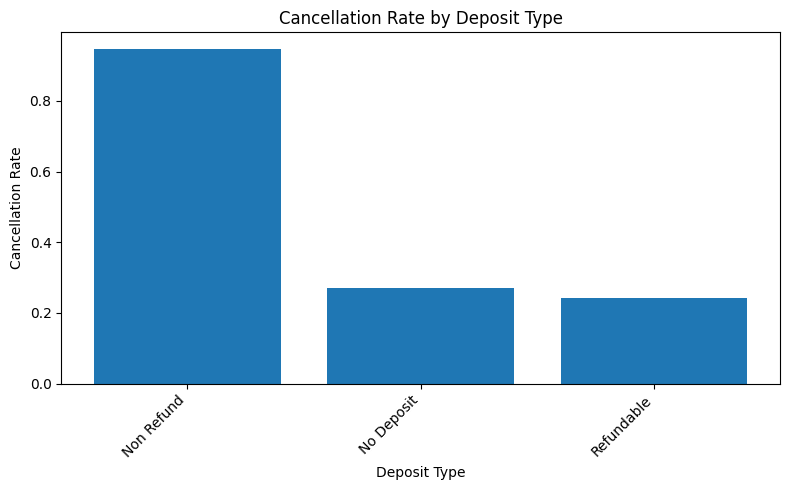

In [21]:
# ============================
# 3. Cancellation rate by deposit_type
# ============================
deposit_type = (
    df.groupBy("deposit_type")
      .agg(
          F.count("*").alias("bookings"),
          F.sum("is_canceled").alias("cancellations")
      )
      .withColumn("cancellation_rate", F.col("cancellations") / F.col("bookings"))
      .orderBy(F.col("cancellation_rate").desc())
)

deposit_rows = deposit_type.collect()

deposit_types = [r["deposit_type"] for r in deposit_rows]
deposit_rates = [r["cancellation_rate"] for r in deposit_rows]

plt.figure(figsize=(8, 5))
plt.bar(deposit_types, deposit_rates)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Deposit Type")
plt.ylabel("Cancellation Rate")
plt.title("Cancellation Rate by Deposit Type")
plt.tight_layout()
plt.show()


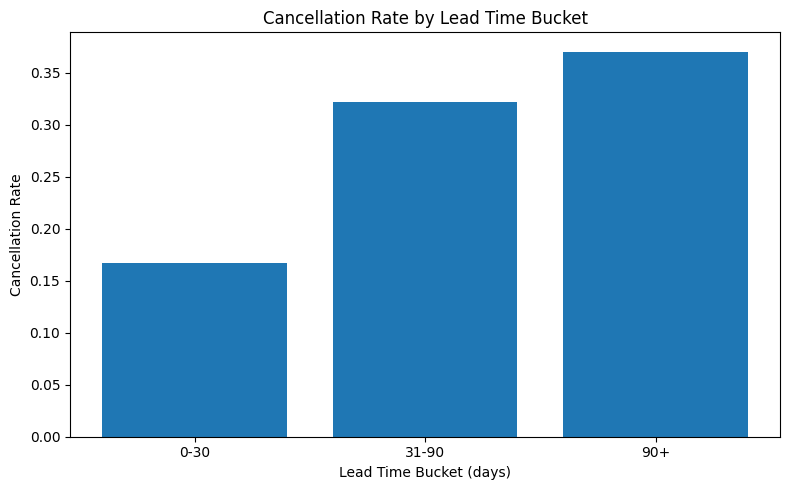

In [22]:
# ============================
# 4. Lead time bucket vs cancellation rate
# ============================
lead_bucket = (
    df_fe.groupBy("lead_time_bucket")
         .agg(
             F.count("*").alias("bookings"),
             F.sum("is_canceled").alias("cancellations")
         )
         .withColumn("cancellation_rate", F.col("cancellations") / F.col("bookings"))
)

lead_rows = lead_bucket.collect()

# Enforce specific bucket order
bucket_order = ["0-30", "31-90", "90+"]
bucket_to_rate = {r["lead_time_bucket"]: r["cancellation_rate"] for r in lead_rows}

buckets_sorted = [b for b in bucket_order if b in bucket_to_rate]
rates_sorted = [bucket_to_rate[b] for b in buckets_sorted]

plt.figure(figsize=(8, 5))
plt.bar(buckets_sorted, rates_sorted)
plt.xlabel("Lead Time Bucket (days)")
plt.ylabel("Cancellation Rate")
plt.title("Cancellation Rate by Lead Time Bucket")
plt.tight_layout()
plt.show()


/tmp/ipykernel_4091/3206549843.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels, showfliers=False)


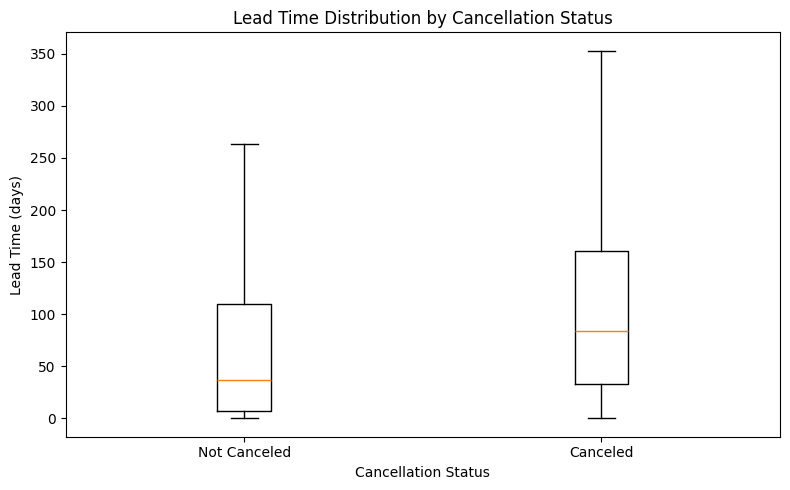

In [23]:
# ============================
# 5. Lead time distribution by cancellation (boxplot)
# ============================
# Sample to limit rows for plotting if dataset is large
lead_sample = (
    df.select("lead_time", "is_canceled")
      .dropna()
      .sample(False, 0.1, seed=42)  # 10% sample; adjust if needed
)

lead_rows = lead_sample.collect()

lead_canceled = [r["lead_time"] for r in lead_rows if r["is_canceled"] == 1]
lead_not_canceled = [r["lead_time"] for r in lead_rows if r["is_canceled"] == 0]

data_to_plot = [lead_not_canceled, lead_canceled]
labels = ["Not Canceled", "Canceled"]

plt.figure(figsize=(8, 5))
plt.boxplot(data_to_plot, labels=labels, showfliers=False)
plt.xlabel("Cancellation Status")
plt.ylabel("Lead Time (days)")
plt.title("Lead Time Distribution by Cancellation Status")
plt.tight_layout()
plt.show()


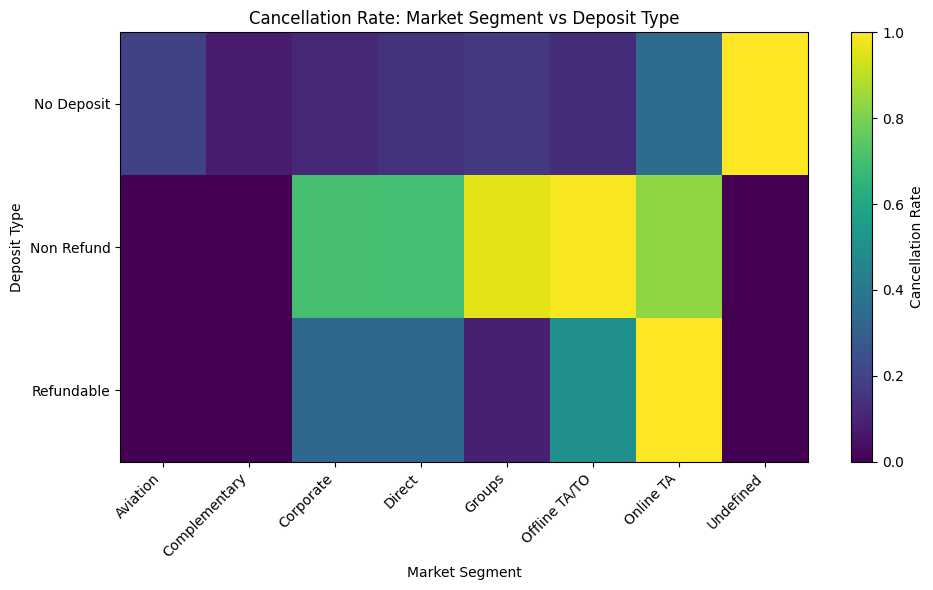

In [24]:
# ============================
# 6. Heatmap: market_segment x deposit_type
# ============================
heat_df = (
    df.groupBy("market_segment", "deposit_type")
      .agg(
          F.count("*").alias("bookings"),
          F.sum("is_canceled").alias("cancellations")
      )
      .withColumn("cancellation_rate", F.col("cancellations") / F.col("bookings"))
)

heat_rows = heat_df.collect()

# Build unique lists for axes
market_segments = sorted({r["market_segment"] for r in heat_rows})
deposit_types = sorted({r["deposit_type"] for r in heat_rows})

# Create lookup dict for cancellation_rate
rate_lookup = {}
for r in heat_rows:
    key = (r["deposit_type"], r["market_segment"])
    rate_lookup[key] = r["cancellation_rate"]

# Build matrix [len(deposit_types) x len(market_segments)]
matrix = []
for dep in deposit_types:
    row = []
    for seg in market_segments:
        row.append(rate_lookup.get((dep, seg), 0.0))
    matrix.append(row)

# Plot heatmap
plt.figure(figsize=(10, 6))
im = plt.imshow(matrix, aspect="auto")

plt.colorbar(im, label="Cancellation Rate")
plt.xticks(range(len(market_segments)), market_segments, rotation=45, ha="right")
plt.yticks(range(len(deposit_types)), deposit_types)
plt.xlabel("Market Segment")
plt.ylabel("Deposit Type")
plt.title("Cancellation Rate: Market Segment vs Deposit Type")
plt.tight_layout()
plt.show()


In [14]:
# ============================
# 0. Imports
# ============================
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# ============================
# 1. Ensure label is numeric
# ============================
df = df.withColumn("is_canceled", F.col("is_canceled").cast("int"))

# ============================
# 2. Categorical encoders (similar style to gender/ethnicity)
# ============================
hotel_label        = StringIndexer(inputCol="hotel",               outputCol="hotelIndex",              handleInvalid="keep")
hotel_onehot       = OneHotEncoder(inputCol="hotelIndex",          outputCol="hotelVec")

month_label        = StringIndexer(inputCol="arrival_date_month",  outputCol="monthIndex",              handleInvalid="keep")
month_onehot       = OneHotEncoder(inputCol="monthIndex",          outputCol="monthVec")

meal_label         = StringIndexer(inputCol="meal",                outputCol="mealIndex",               handleInvalid="keep")
meal_onehot        = OneHotEncoder(inputCol="mealIndex",           outputCol="mealVec")

country_label      = StringIndexer(inputCol="country",             outputCol="countryIndex",            handleInvalid="keep")
country_onehot     = OneHotEncoder(inputCol="countryIndex",        outputCol="countryVec")

mkt_label          = StringIndexer(inputCol="market_segment",      outputCol="marketIndex",             handleInvalid="keep")
mkt_onehot         = OneHotEncoder(inputCol="marketIndex",         outputCol="marketVec")

dist_label         = StringIndexer(inputCol="distribution_channel",outputCol="distIndex",               handleInvalid="keep")
dist_onehot        = OneHotEncoder(inputCol="distIndex",           outputCol="distVec")

resroom_label      = StringIndexer(inputCol="reserved_room_type",  outputCol="resRoomIndex",            handleInvalid="keep")
resroom_onehot     = OneHotEncoder(inputCol="resRoomIndex",        outputCol="resRoomVec")

assroom_label      = StringIndexer(inputCol="assigned_room_type",  outputCol="assRoomIndex",            handleInvalid="keep")
assroom_onehot     = OneHotEncoder(inputCol="assRoomIndex",        outputCol="assRoomVec")

deposit_label      = StringIndexer(inputCol="deposit_type",        outputCol="depositIndex",            handleInvalid="keep")
deposit_onehot     = OneHotEncoder(inputCol="depositIndex",        outputCol="depositVec")

agent_label        = StringIndexer(inputCol="agent",               outputCol="agentIndex",              handleInvalid="keep")
agent_onehot       = OneHotEncoder(inputCol="agentIndex",          outputCol="agentVec")

company_label      = StringIndexer(inputCol="company",             outputCol="companyIndex",            handleInvalid="keep")
company_onehot     = OneHotEncoder(inputCol="companyIndex",        outputCol="companyVec")

cust_label         = StringIndexer(inputCol="customer_type",       outputCol="customerIndex",           handleInvalid="keep")
cust_onehot        = OneHotEncoder(inputCol="customerIndex",       outputCol="customerVec")

# ============================
# 3. Numeric variables
# ============================
numeric_vars = [
    "lead_time",
    "arrival_date_year",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests"
]

# ============================
# 4. Assembler + MinMaxScaler + Logistic
# ============================
onehot_vars1 = numeric_vars + [
    "hotelVec",
    "monthVec",
    "mealVec",
    "countryVec",
    "marketVec",
    "distVec",
    "resRoomVec",
    "assRoomVec",
    "depositVec",
    "agentVec",
    "companyVec",
    "customerVec"
]

assembler1 = VectorAssembler(inputCols=onehot_vars1, outputCol="ind_vars_assembler")
scaler1    = MinMaxScaler(inputCol="ind_vars_assembler", outputCol="scaledFeatures")

predictor1 = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="is_canceled",
    maxIter=50,
    regParam=0.01,
    elasticNetParam=0.0
)

# Pipeline in the **same style** as your example
pipeline1 = Pipeline(stages=[
    hotel_label, hotel_onehot,
    month_label, month_onehot,
    meal_label, meal_onehot,
    country_label, country_onehot,
    mkt_label, mkt_onehot,
    dist_label, dist_onehot,
    resroom_label, resroom_onehot,
    assroom_label, assroom_onehot,
    deposit_label, deposit_onehot,
    agent_label, agent_onehot,
    company_label, company_onehot,
    cust_label, cust_onehot,
    assembler1,
    scaler1,
    predictor1
])

# ============================
# 5. Train-test split
# ============================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ============================
# 6. Fit & predict
# ============================
fit1 = pipeline1.fit(train_df)
predictions1 = fit1.transform(test_df)

# ============================
# 7. Evaluate (AUC)
# ============================
evaluator = BinaryClassificationEvaluator(
    labelCol="is_canceled",
    rawPredictionCol="rawPrediction"
)

auc1 = evaluator.evaluate(predictions1)
print("Pipeline 1: Logistic Regression AUC:", auc1)

# Optional: see a few predictions
predictions1.select("is_canceled", "probability", "prediction").show(10, truncate=False)


25/11/28 18:59:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Pipeline 1: Logistic Regression AUC: 0.8603606822195461
+-----------+------------------------------------------+----------+
|is_canceled|probability                               |prediction|
+-----------+------------------------------------------+----------+
|0          |[0.9969611839619287,0.0030388160380713236]|0.0       |
|0          |[0.9284581474827222,0.07154185251727785]  |0.0       |
|0          |[0.9170265120383418,0.08297348796165815]  |0.0       |
|0          |[0.9377343307310113,0.06226566926898869]  |0.0       |
|0          |[0.9045717000729022,0.09542829992709778]  |0.0       |
|0          |[0.8447354665338331,0.15526453346616687]  |0.0       |
|0          |[0.8111332390136742,0.18886676098632582]  |0.0       |
|0          |[0.9240157187254332,0.0759842812745668]   |0.0       |
|0          |[0.5534316551655348,0.44656834483446517]  |0.0       |
|0          |[0.35929691962410165,0.6407030803758984]  |1.0       |
+-----------+------------------------------------------+----

In [15]:
# ============================================
# IMPORTS 
# ============================================
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# ============================================
# 1. Make sure label is numeric
# ============================================
df = df.withColumn("is_canceled", F.col("is_canceled").cast("int"))

# ============================================
# 2. Categorical encoders 
# ============================================
hotel_label        = StringIndexer(inputCol="hotel",               outputCol="hotelIndex",              handleInvalid="keep")
hotel_onehot       = OneHotEncoder(inputCol="hotelIndex",          outputCol="hotelVec")

month_label        = StringIndexer(inputCol="arrival_date_month",  outputCol="monthIndex",              handleInvalid="keep")
month_onehot       = OneHotEncoder(inputCol="monthIndex",          outputCol="monthVec")

meal_label         = StringIndexer(inputCol="meal",                outputCol="mealIndex",               handleInvalid="keep")
meal_onehot        = OneHotEncoder(inputCol="mealIndex",           outputCol="mealVec")

country_label      = StringIndexer(inputCol="country",             outputCol="countryIndex",            handleInvalid="keep")
country_onehot     = OneHotEncoder(inputCol="countryIndex",        outputCol="countryVec")

mkt_label          = StringIndexer(inputCol="market_segment",      outputCol="marketIndex",             handleInvalid="keep")
mkt_onehot         = OneHotEncoder(inputCol="marketIndex",         outputCol="marketVec")

dist_label         = StringIndexer(inputCol="distribution_channel",outputCol="distIndex",               handleInvalid="keep")
dist_onehot        = OneHotEncoder(inputCol="distIndex",           outputCol="distVec")

resroom_label      = StringIndexer(inputCol="reserved_room_type",  outputCol="resRoomIndex",            handleInvalid="keep")
resroom_onehot     = OneHotEncoder(inputCol="resRoomIndex",        outputCol="resRoomVec")

assroom_label      = StringIndexer(inputCol="assigned_room_type",  outputCol="assRoomIndex",            handleInvalid="keep")
assroom_onehot     = OneHotEncoder(inputCol="assRoomIndex",        outputCol="assRoomVec")

deposit_label      = StringIndexer(inputCol="deposit_type",        outputCol="depositIndex",            handleInvalid="keep")
deposit_onehot     = OneHotEncoder(inputCol="depositIndex",        outputCol="depositVec")

agent_label        = StringIndexer(inputCol="agent",               outputCol="agentIndex",              handleInvalid="keep")
agent_onehot       = OneHotEncoder(inputCol="agentIndex",          outputCol="agentVec")

company_label      = StringIndexer(inputCol="company",             outputCol="companyIndex",            handleInvalid="keep")
company_onehot     = OneHotEncoder(inputCol="companyIndex",        outputCol="companyVec")

cust_label         = StringIndexer(inputCol="customer_type",       outputCol="customerIndex",           handleInvalid="keep")
cust_onehot        = OneHotEncoder(inputCol="customerIndex",       outputCol="customerVec")

# All one-hot vector outputs (used later in RF pipeline)
categorical_vecs = [
    "hotelVec",
    "monthVec",
    "mealVec",
    "countryVec",
    "marketVec",
    "distVec",
    "resRoomVec",
    "assRoomVec",
    "depositVec",
    "agentVec",
    "companyVec",
    "customerVec"
]

# ============================================
# 3. Numeric variables
# ============================================
numeric_vars = [
    "lead_time",
    "arrival_date_year",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "is_repeated_guest",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests"
]

# ============================================
# 4. Train–test split
# ============================================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ============================================
# 5. FEATURE SELECTION PIPELINE (Decision Tree)
#    Pipeline 2 style: assemble numeric features -> DecisionTree -> importances
# ============================================
onehot_vars2 = numeric_vars   # only numeric for selection step (keeps mapping clean)

assembler_features2 = VectorAssembler(
    inputCols=onehot_vars2,
    outputCol="vars_assembler2"
)

model_features2 = DecisionTreeClassifier(
    featuresCol="vars_assembler2",
    labelCol="is_canceled",
    maxDepth=5
)

pipeline_features2 = Pipeline(stages=[assembler_features2, model_features2])

fit_features2 = pipeline_features2.fit(train_df)

# Get feature importances and select most important (threshold can be tuned)
importances2 = fit_features2.stages[-1].featureImportances.toArray()
selected_features2 = [onehot_vars2[i] for i, imp in enumerate(importances2) if imp > 0.01]

print("Pipeline 2 - selected numeric features from Decision Tree:")
print(selected_features2)

# If nothing passes threshold (rare), fall back to using all numeric features
if len(selected_features2) == 0:
    selected_features2 = onehot_vars2
    print("No features passed threshold; using all numeric features instead.")

# ============================================
# 6. RANDOM FOREST PIPELINE WITH SELECTED FEATURES
#    Assembler with selected numeric + all categorical one-hot vectors
# ============================================
assembler2 = VectorAssembler(
    inputCols=selected_features2 + categorical_vecs,
    outputCol="selected2_assembler"
)

predictor2 = RandomForestClassifier(
    featuresCol="selected2_assembler",
    labelCol="is_canceled",
    numTrees=200,
    maxDepth=10,
    seed=42
)

pipeline2 = Pipeline(stages=[
    hotel_label, hotel_onehot,
    month_label, month_onehot,
    meal_label, meal_onehot,
    country_label, country_onehot,
    mkt_label, mkt_onehot,
    dist_label, dist_onehot,
    resroom_label, resroom_onehot,
    assroom_label, assroom_onehot,
    deposit_label, deposit_onehot,
    agent_label, agent_onehot,
    company_label, company_onehot,
    cust_label, cust_onehot,
    assembler2,
    predictor2
])

fit2 = pipeline2.fit(train_df)
predictions2 = fit2.transform(test_df)

# ============================================
# 7. Evaluate AUC (same style as your evaluator)
# ============================================
evaluator = BinaryClassificationEvaluator(
    labelCol="is_canceled",
    rawPredictionCol="rawPrediction"
)

auc2 = evaluator.evaluate(predictions2)
print("Pipeline 2 (Random Forest with selected features) AUC:", auc2)

# Optional: preview predictions
predictions2.select("is_canceled", "probability", "prediction").show(10, truncate=False)


Pipeline 2 - selected numeric features from Decision Tree:
['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


25/11/28 19:00:08 WARN DAGScheduler: Broadcasting large task binary with size 1063.6 KiB
25/11/28 19:00:10 WARN DAGScheduler: Broadcasting large task binary with size 1458.1 KiB
25/11/28 19:00:12 WARN DAGScheduler: Broadcasting large task binary with size 2026.4 KiB
25/11/28 19:00:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
25/11/28 19:00:17 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/11/28 19:00:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/11/28 19:00:25 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
25/11/28 19:00:31 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


Pipeline 2 (Random Forest with selected features) AUC: 0.8521201071681738


25/11/28 19:00:33 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


+-----------+----------------------------------------+----------+
|is_canceled|probability                             |prediction|
+-----------+----------------------------------------+----------+
|0          |[0.8367767400179367,0.16322325998206344]|0.0       |
|0          |[0.8323128106522573,0.16768718934774282]|0.0       |
|0          |[0.7685942693501787,0.23140573064982128]|0.0       |
|0          |[0.7677525743438923,0.23224742565610776]|0.0       |
|0          |[0.7711861887129372,0.22881381128706282]|0.0       |
|0          |[0.813816613619214,0.18618338638078602] |0.0       |
|0          |[0.7596669573890469,0.24033304261095306]|0.0       |
|0          |[0.8322408808532801,0.16775911914671995]|0.0       |
|0          |[0.711694034357918,0.288305965642082]   |0.0       |
|0          |[0.6693651495697268,0.33063485043027313]|0.0       |
+-----------+----------------------------------------+----------+
only showing top 10 rows



In [27]:
# ============================================
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, PCA
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# ============================================
# Pipeline 3: Label Encoding, PCA, then GBT
# ============================================

# Label-encoded (index) features we’ll feed into PCA
label_vars4 = numeric_vars + [
    "hotelIndex",
    "monthIndex",
    "mealIndex",
    "countryIndex",
    "marketIndex",
    "distIndex",
    "resRoomIndex",
    "assRoomIndex",
    "depositIndex",
    "agentIndex",
    "companyIndex",
    "customerIndex"
]

assembler_features4 = VectorAssembler(
    inputCols=label_vars4,
    outputCol="vars_assembler4"
)

# Choose number of principal components (tune k if you want)
pca_gbt = PCA(
    k=20,                        # you can try 10, 20, etc.
    inputCol="vars_assembler4",
    outputCol="selected4_assembler"
)

# GBT Classifier on PCA-transformed features
predictor4 = GBTClassifier(
    featuresCol="selected4_assembler",
    labelCol="is_canceled",
    maxIter=100,
    maxDepth=5,
    stepSize=0.1,
    seed=42
)

# Full pipeline in the same style as your diabetes Pipeline 4
pipeline4 = Pipeline(stages=[
    hotel_label,
    month_label,
    meal_label,
    country_label,
    mkt_label,
    dist_label,
    resroom_label,
    assroom_label,
    deposit_label,
    agent_label,
    company_label,
    cust_label,
    assembler_features4,
    pca_gbt,
    predictor4
])

# ============================================
# 5. Train–test split
# ============================================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ============================================
# 6. Fit & predict
# ============================================
fit4 = pipeline4.fit(train_df)
predictions4 = fit4.transform(test_df)

# ============================================
# 7. Evaluate AUC
# ============================================
evaluator = BinaryClassificationEvaluator(
    labelCol="is_canceled",
    rawPredictionCol="rawPrediction"
)

auc4 = evaluator.evaluate(predictions4)
print("AUC (GBTClassifier with PCA-reduced features):", auc4)

# Optional: inspect some predictions
predictions4.select("is_canceled", "probability", "prediction").show(10, truncate=False)


AUC (GBTClassifier with PCA-reduced features): 0.85887649161651
+-----------+-----------------------------------------+----------+
|is_canceled|probability                              |prediction|
+-----------+-----------------------------------------+----------+
|0          |[0.9795845652738574,0.0204154347261426]  |0.0       |
|0          |[0.9724509135924742,0.027549086407525847]|0.0       |
|0          |[0.9782606161747645,0.021739383825235548]|0.0       |
|0          |[0.9805971753817676,0.019402824618232395]|0.0       |
|0          |[0.9357818186896685,0.06421818131033152] |0.0       |
|0          |[0.8453965133409346,0.15460348665906543] |0.0       |
|0          |[0.8624739238658526,0.13752607613414736] |0.0       |
|0          |[0.9465727512334563,0.0534272487665437]  |0.0       |
|0          |[0.9245663884282979,0.07543361157170214] |0.0       |
|0          |[0.8210453556235039,0.1789546443764961]  |0.0       |
+-----------+-----------------------------------------+----------

In [17]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

# Make sure evaluator is set for the correct label
evaluator = BinaryClassificationEvaluator(
    labelCol="is_canceled",
    rawPredictionCol="rawPrediction"
)

results = []

for label, pred_df in [
    ("Pipeline 1: Logistic Regression", predictions1),
    ("Pipeline 2: Random Forest",       predictions2),
    ("Pipeline 3: GBT + PCA",           predictions4),
]:
    # AUC
    auc = evaluator.evaluate(pred_df)
    
    # Accuracy: compare is_canceled vs prediction
    correct = pred_df.filter(F.col("is_canceled") == F.col("prediction")).count()
    total   = pred_df.count()
    acc = correct / total if total > 0 else None
    
    results.append({
        "Pipeline": label,
        "AUC": auc,
        "Accuracy": acc
    })

# As pandas table (no toPandas involved)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# If you prefer a Spark DataFrame instead:
results_spark_df = spark.createDataFrame(results)
results_spark_df.show(truncate=False)


25/11/28 19:01:26 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/11/28 19:01:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


                       Pipeline      AUC  Accuracy
Pipeline 1: Logistic Regression 0.860361  0.799153
      Pipeline 2: Random Forest 0.852117  0.729968
          Pipeline 3: GBT + PCA 0.858874  0.812802
+------------------+------------------+-------------------------------+
|AUC               |Accuracy          |Pipeline                       |
+------------------+------------------+-------------------------------+
|0.8603610837354169|0.7991528415107659|Pipeline 1: Logistic Regression|
|0.8521172880141854|0.7299682315566537|Pipeline 2: Random Forest      |
|0.8588744413227003|0.8128015060595364|Pipeline 3: GBT + PCA          |
+------------------+------------------+-------------------------------+



25/11/28 19:01:34 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


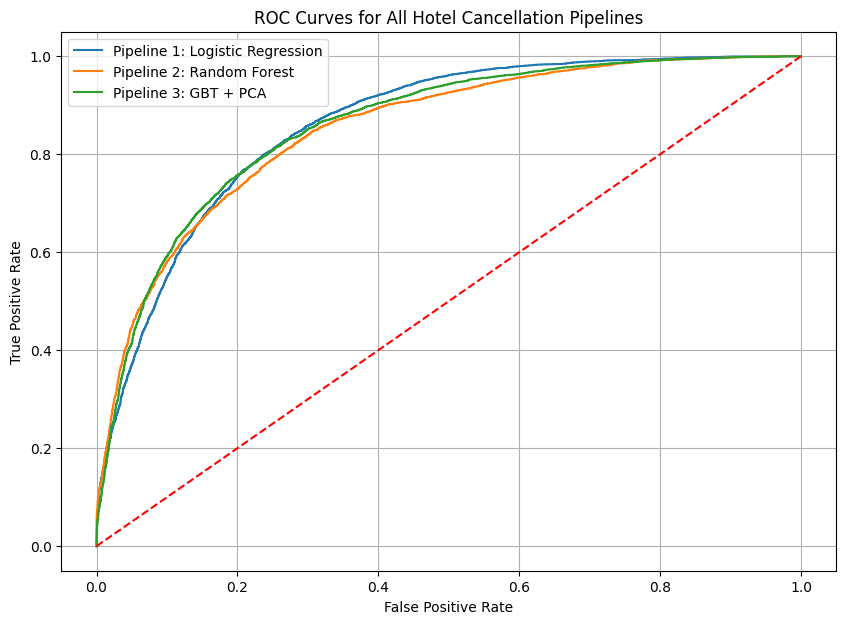

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))

pipelines = [
    ("Pipeline 1: Logistic Regression", predictions1),
    ("Pipeline 2: Random Forest",       predictions2),
    ("Pipeline 3: GBT + PCA",           predictions4)
]

for name, pred_df in pipelines:
    
    # Extract true labels
    y_true = [row.is_canceled for row in pred_df.select("is_canceled").collect()]
    
    # Extract probability of class 1 (second element of probability vector)
    y_score = []
    for row in pred_df.select("probability").collect():
        # probability column is a DenseVector([p0, p1])
        vec = row.probability
        prob1 = float(vec[1]) if hasattr(vec, "__getitem__") else float(vec)
        y_score.append(prob1)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=name)

# Diagonal baseline
plt.plot([0,1], [0,1], 'r--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Hotel Cancellation Pipelines")
plt.legend()
plt.grid(True)
plt.show()
